# Assignment 0

    Author: Group F - Gaurav, Xiaowen Sun, Jheel Harnish Kamdar, Ruijia Xiong
    Created at: 02/15/2023

In [ ]:
# Data processing and visualization
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Natural language processing
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
import re

# Machine learning and deep learning libraries
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Embedding, Conv1D, GlobalMaxPooling1D
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [ ]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/News_Category_Dataset_v3.csv'

MessageError: Error: credential propagation was unsuccessful

In [ ]:
# Assuming the dataset is in CSV format
df = pd.read_csv(file_path, index_col='Unnamed: 0')
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 209527 entries, 0 to 209526
Data columns (total 7 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   headline                  209521 non-null  object
 1   category                  209527 non-null  object
 2   short_description         189815 non-null  object
 3   authors                   172109 non-null  object
 4   date                      209527 non-null  object
 5   headline_length           209527 non-null  int64 
 6   short_description_length  209527 non-null  int64 
dtypes: int64(2), object(5)
memory usage: 12.8+ MB


In [ ]:
# Count the number of categories
df['category'].nunique()

42

In [ ]:
df['category'] = df['category'].replace('PARENTS', 'PARENTING')
df['category'] = df['category'].replace('STYLE', 'STYLE & BEAUTY')
df['category'] = df['category'].replace('THE WORLDPOST', 'WORLDPOST')

df['category'] = df['category'].replace('ARTS', 'ARTS & CULTURE')
df['category'] = df['category'].replace('CULTURE & ARTS', 'ARTS & CULTURE')
df['category'] = df['category'].replace('HEALTHY LIVING', 'WELLNESS')

In [ ]:
df['category'].nunique()

36

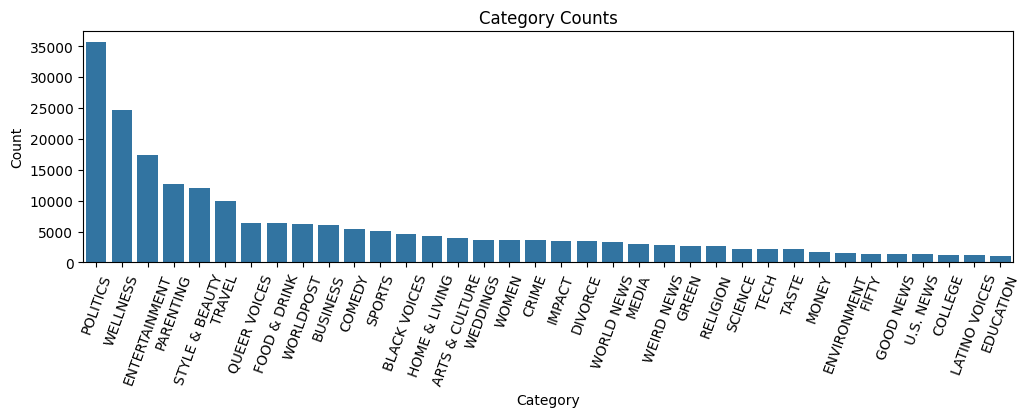

In [ ]:
category_counts = df['category'].value_counts()

# Create a bar plot (histogram) of the category counts using seaborn
plt.figure(figsize=(12, 3))
sns.barplot(x=category_counts.index, y=category_counts.values)
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Category Counts')
plt.xticks(rotation=70)
plt.show()

In [ ]:
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Check if the text is a string
    if not isinstance(text, str):
        return text

    # Lowercase
    text = text.lower()
    # Remove special characters
    text = re.sub(r'\W', ' ', text)
    # Remove single characters
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
    # Remove single characters from the start
    text = re.sub(r'\^[a-zA-Z]\s+', ' ', text)
    # Substitute multiple spaces with single space
    text = re.sub(r'\s+', ' ', text, flags=re.I)
    # remove text in square brackets
    text = re.sub('\[.*?\]', '', text)
    # remove links
    text = re.sub('https?://\S+|www\.\S+', '', text)
    # remove punctuation
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    # remove words containing numbers
    text = re.sub('\w*\d\w*', '', text)
    # Remove stopwords
    tokens = word_tokenize(text)
    filtered_text = ' '.join([word for word in tokens if word not in stop_words])
    return filtered_text


# Applying the preprocess function to each row of the headline and short description
df['cleaned_headline'] = df['headline'].apply(preprocess_text)
df['cleaned_short_description'] = df['short_description'].apply(preprocess_text)
df.head(5)

,headline,category,short_description,authors,date,headline_length,short_description_length,cleaned_headline,cleaned_short_description
0,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23,76,154,million americans roll sleeves omicron targete...,health experts said early predict whether dema...
1,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23,89,159,american airlines flyer charged banned life pu...,subdued passengers crew fled back aircraft con...
2,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23,69,64,funniest tweets cats dogs week sept,dog understand could eaten
3,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23,56,159,funniest tweets parents week sept,accidentally put grown toothpaste toddler toot...
4,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski,2022-09-22,77,156,woman called cops black bird watcher loses law...,amy cooper accused investment firm franklin te...


In [ ]:
# Combine cleaned headline and short description for vectorization
df['combined_text'] = df['cleaned_headline'] + ' ' + df['cleaned_short_description']
df['combined_text'] = df['combined_text'].fillna('')

In [ ]:
# Initialize a TF-IDF Vectorizer
# vectorizer = TfidfVectorizer(ngram_range=(1, 1))
vectorizer = TfidfVectorizer(max_df=0.80, min_df=500)

# Fit and transform the combined text
feature_vector = vectorizer.fit_transform(df['combined_text'])


In [ ]:
# Get the feature names
feature_names = vectorizer.get_feature_names_out()

# Print the number of features (tokens)
print("Number of features:", len(feature_names))

# Print the first 100 features'
print(f"First 100 features: \n{feature_names[0:100]}")

Number of features: 1233
First 100 features: 
['ability' 'able' 'abortion' 'absolutely' 'abuse' 'access' 'according'
 'accused' 'across' 'act' 'action' 'actor' 'actress' 'actually' 'ad' 'add'
 'address' 'administration' 'adorable' 'adults' 'advice' 'african' 'age'
 'ago' 'ahead' 'air' 'allegedly' 'allow' 'almost' 'alone' 'along'
 'already' 'also' 'although' 'always' 'amazing' 'america' 'american'
 'americans' 'amid' 'among' 'angeles' 'animal' 'anniversary' 'announced'
 'annual' 'another' 'answer' 'anti' 'anxiety' 'anyone' 'anything'
 'apparently' 'apple' 'approach' 'april' 'area' 'around' 'arrested' 'art'
 'artist' 'ask' 'asked' 'asking' 'assault' 'attack' 'attacks' 'attention'
 'attorney' 'author' 'avoid' 'award' 'awards' 'awareness' 'away' 'awesome'
 'babies' 'baby' 'back' 'bad' 'ban' 'bank' 'based' 'battle' 'beach'
 'beautiful' 'beauty' 'became' 'become' 'becomes' 'becoming' 'began'
 'begin' 'beginning' 'behavior' 'behind' 'believe' 'benefits' 'bernie'
 'best']


In [ ]:
dtm = pd.DataFrame(feature_vector.toarray(), columns=feature_names)
dtm

,ability,able,abortion,absolutely,abuse,access,according,accused,across,act,...,writing,wrong,wrote,year,years,yes,yet,yoga,york,young
0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.291106,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.33387,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209522,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
209523,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.308914,0.0,0.0,0.0,0.0,0.0
209524,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.187299,0.0,0.0,0.0,0.0,0.0
209525,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


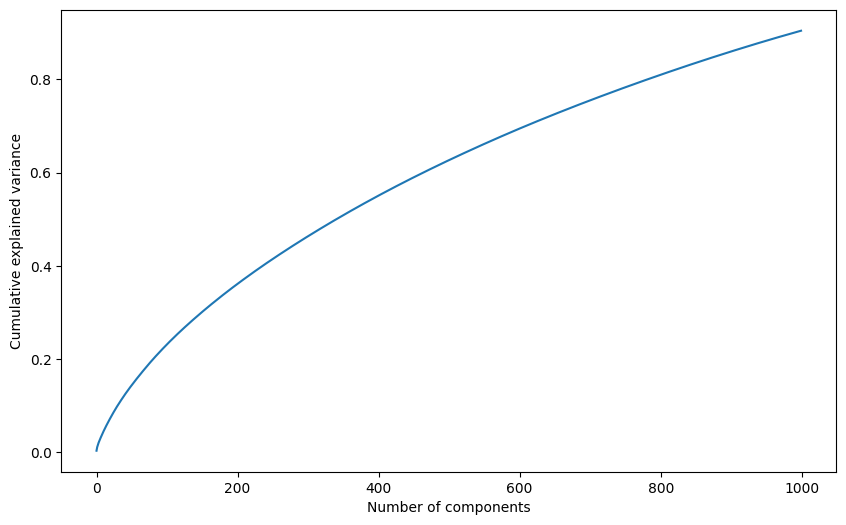

In [ ]:
# Example with TruncatedSVD
svd = TruncatedSVD(n_components=1000)  # Start with a larger number of components
reduced_data = svd.fit_transform(dtm)

# Plot the cumulative explained variance
plt.figure(figsize=(10,6))
plt.plot(np.cumsum(svd.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.show()

In [ ]:
n_components = 800  # Number of components to keep
svd = TruncatedSVD(n_components=n_components)
reduced_data = svd.fit_transform(dtm)
print(f"Total variance explained: {np.sum(svd.explained_variance_ratio_):.2f}")

Total variance explained: 0.81


In [ ]:
# Assuming 'category' is the target variable and 'tfidf_matrix' is your features matrix
X_train, X_test, y_train, y_test = train_test_split(feature_vector, df['category'], test_size=0.2, random_state=42)
X_train_dr, X_test_dr, y_train_dr, y_test_dr = train_test_split(reduced_data, df['category'], test_size=0.2, random_state=42)


In [ ]:
# Initialize and train the logistic regression model
lr_0 = LogisticRegression()
lr_0.fit(X_train_dr, y_train_dr)

# Predict on the test set
lr_pred_0 = lr_0.predict(X_test_dr)

# Evaluate performance
lr_report_0 = classification_report(y_test_dr, lr_pred_0)
print("Logistic Regression Report:\n", lr_report_0)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels wit

Logistic Regression Report:
                 precision    recall  f1-score   support

ARTS & CULTURE       0.39      0.18      0.25       770
  BLACK VOICES       0.44      0.22      0.29       889
      BUSINESS       0.39      0.25      0.30      1216
       COLLEGE       0.31      0.14      0.19       202
        COMEDY       0.44      0.22      0.29      1022
         CRIME       0.45      0.34      0.39       713
       DIVORCE       0.77      0.54      0.64       664
     EDUCATION       0.36      0.17      0.23       209
 ENTERTAINMENT       0.28      0.65      0.39      3419
   ENVIRONMENT       0.50      0.16      0.24       313
         FIFTY       0.11      0.01      0.01       263
  FOOD & DRINK       0.54      0.49      0.52      1270
     GOOD NEWS       0.31      0.02      0.03       270
         GREEN       0.28      0.13      0.18       532
 HOME & LIVING       0.59      0.49      0.53       879
        IMPACT       0.25      0.09      0.13       673
 LATINO VOICES    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Compute confusion matrix
cm_lr = confusion_matrix(y_test_dr, lr_pred_0)
# Plot the confusion matrix
plt.figure(figsize=(15, 12))
sns.heatmap(cm_lr, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_test_dr), yticklabels=np.unique(y_test_dr))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Logistic Regression')
plt.show()


In [ ]:
# # Initialize and train the logistic regression model
# log_reg = LogisticRegression()
# log_reg.fit(X_train, y_train)

# # Predict on the test set
# log_reg_pred = log_reg.predict(X_test)

# # Evaluate performance
# log_reg_report = classification_report(y_test, log_reg_pred)
# print("Logistic Regression Report:\n", log_reg_report)

In [ ]:
# Initialize and train the random forest classifier
rf_clf = RandomForestClassifier()
rf_clf.fit(X_train, y_train)

# Predict on the test set
rf_pred = rf_clf.predict(X_test)

# Evaluate performance
rf_report = classification_report(y_test, rf_pred)
print("Random Forest Report:\n", rf_report)


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Random Forest Report:
                 precision    recall  f1-score   support

ARTS & CULTURE       0.39      0.18      0.24       770
  BLACK VOICES       0.46      0.25      0.32       889
      BUSINESS       0.40      0.23      0.29      1216
       COLLEGE       0.28      0.16      0.20       202
        COMEDY       0.48      0.22      0.30      1022
         CRIME       0.42      0.25      0.32       713
       DIVORCE       0.85      0.55      0.67       664
     EDUCATION       0.40      0.15      0.22       209
 ENTERTAINMENT       0.40      0.47      0.43      3419
   ENVIRONMENT       0.67      0.11      0.19       313
         FIFTY       0.00      0.00      0.00       263
  FOOD & DRINK       0.48      0.51      0.50      1270
     GOOD NEWS       0.14      0.01      0.02       270
         GREEN       0.27      0.11      0.15       532
 HOME & LIVING       0.55      0.49      0.52       879
        IMPACT       0.23      0.02      0.03       673
 LATINO VOICES       0.0

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cm_rf = confusion_matrix(y_test, rf_pred)

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Plotting the confusion matrix
plt.figure(figsize=(15, 12))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Random Forest')
plt.show()


In [ ]:
# Encode class values as integers
encoder = LabelEncoder()
encoder.fit(df['category'])  # Fit on the original category data
encoded_Y_train = encoder.transform(y_train)  # Transform training labels
encoded_Y_test = encoder.transform(y_test)  # Transform test labels


In [ ]:
# Initialize and train the XGBoost classifier with encoded labels
xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb_clf.fit(X_train, encoded_Y_train)

# Predict on the test set using encoded labels
xgb_pred = xgb_clf.predict(X_test)

# Since the predictions are in encoded form, use the inverse_transform method to get back to string labels for evaluation
xgb_pred_labels = encoder.inverse_transform(xgb_pred)
y_test_labels = encoder.inverse_transform(encoded_Y_test)

# Evaluate performance
xgb_report = classification_report(y_test_labels, xgb_pred_labels)
print("XGBoost Report:\n", xgb_report)



XGBoost Report:
                 precision    recall  f1-score   support

      BUSINESS       0.54      0.25      0.34      1147
 ENTERTAINMENT       0.44      0.74      0.55      3429
  FOOD & DRINK       0.65      0.48      0.55      1276
HEALTHY LIVING       0.42      0.05      0.09      1395
     PARENTING       0.70      0.67      0.68      1804
      POLITICS       0.77      0.79      0.78      7164
  QUEER VOICES       0.80      0.54      0.64      1297
STYLE & BEAUTY       0.76      0.75      0.75      1924
        TRAVEL       0.67      0.50      0.57      1979
      WELLNESS       0.59      0.71      0.65      3543

      accuracy                           0.64     24958
     macro avg       0.63      0.55      0.56     24958
  weighted avg       0.65      0.64      0.63     24958



In [ ]:
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cm_xgb = confusion_matrix(y_test_labels, xgb_pred_labels)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Plotting the confusion matrix
plt.figure(figsize=(16, 13))
sns.heatmap(cm_xgb, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_test_labels), yticklabels=np.unique(y_test_labels))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for XGBoost')
plt.show()


In [ ]:
# Convert integers to dummy (one-hot encoded) variables
y_train_one_hot = to_categorical(encoded_Y_train)
y_test_one_hot = to_categorical(encoded_Y_test)

In [ ]:
# Define the ANN model
ann_model = Sequential()
ann_model.add(Dense(64, activation='relu', input_dim=X_train.shape[1]))
ann_model.add(Dense(32, activation='relu'))
ann_model.add(Dense(len(df['category'].unique()), activation='softmax'))  # Number of classes

# Compile the model
ann_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# # Fit the model to the training data
# ann_model.fit(X_train.toarray(), y_train, epochs=10, batch_size=128)

# # Evaluate the model on the test data
# ann_loss, ann_accuracy = ann_model.evaluate(X_test.toarray(), y_test)
# print("ANN Accuracy:", ann_accuracy)
# Fit the model to the training data
ann_model.fit(X_train.toarray(), y_train_one_hot, epochs=10, batch_size=128)

# Evaluate the model on the test data
ann_loss, ann_accuracy = ann_model.evaluate(X_test.toarray(), y_test_one_hot)
print("ANN Accuracy:", ann_accuracy)


Epoch 1/10
780/780 [==============================] - 5s 3ms/step - loss: 1.3181 - accuracy: 0.5753
Epoch 2/10
780/780 [==============================] - 3s 4ms/step - loss: 1.0592 - accuracy: 0.6524
Epoch 3/10
780/780 [==============================] - 2s 3ms/step - loss: 1.0348 - accuracy: 0.6572
Epoch 4/10
780/780 [==============================] - 3s 3ms/step - loss: 1.0191 - accuracy: 0.6597
Epoch 5/10
780/780 [==============================] - 3s 3ms/step - loss: 1.0065 - accuracy: 0.6634
Epoch 6/10
780/780 [==============================] - 3s 4ms/step - loss: 0.9948 - accuracy: 0.6667
Epoch 7/10
780/780 [==============================] - 3s 4ms/step - loss: 0.9846 - accuracy: 0.6701
Epoch 8/10
780/780 [==============================] - 3s 3ms/step - loss: 0.9736 - accuracy: 0.6724
Epoch 9/10
780/780 [==============================] - 3s 3ms/step - loss: 0.9631 - accuracy: 0.6757
Epoch 10/10
780/780 [==============================] - 3s 3ms/step - loss: 1.0403 - accuracy: 0.6553

In [ ]:
# Generate predictions for X_test
ann_pred_prob = ann_model.predict(X_test.toarray())
# Convert probabilities to class labels
ann_pred_labels = np.argmax(ann_pred_prob, axis=1)
true_labels = np.argmax(y_test_one_hot, axis=1)

from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cm_ann = confusion_matrix(true_labels, ann_pred_labels)

import matplotlib.pyplot as plt
import seaborn as sns

# Plot the confusion matrix
plt.figure(figsize=(16, 14))
sns.heatmap(cm_ann, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(true_labels), yticklabels=np.unique(true_labels))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for ANN')
plt.show()


In [ ]:
# Initialize the tokenizer
tokenizer = Tokenizer(num_words=10000)  # num_words is the maximum number of words to keep, based on word frequency

# Fit the tokenizer on the text data
tokenizer.fit_on_texts(df['combined_text'])

# Convert text to sequences of integers
sequences = tokenizer.texts_to_sequences(df['combined_text'])

# The tokenizer provides a word index dictionary mapping words to integers
word_index = tokenizer.word_index
print(f'Found {len(word_index)} unique tokens.')


Found 65615 unique tokens.


In [ ]:
# Assuming you've already defined 'sequences'
# Pad sequences to ensure uniform length, choosing a max length
max_length = max([len(seq) for seq in sequences])  # You can choose a different strategy for setting max_length

# Pad the sequences
data = pad_sequences(sequences, maxlen=max_length)

print(f'Shape of data tensor: {data.shape}')



Shape of data tensor: (124787, 124)


In [ ]:
# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and return encoded integer labels
labels_encoded = label_encoder.fit_transform(df['category'])

# Convert integers to one-hot encoded labels
labels_one_hot = to_categorical(labels_encoded)

print(f'Shape of label tensor: {labels_one_hot.shape}')


Shape of label tensor: (124787, 10)


In [ ]:
# Split the data into a training set and a testing set
X_train, X_test, y_train_one_hot, y_test_one_hot = train_test_split(data, labels_one_hot, test_size=0.2, random_state=42)

print(X_train.shape, X_test.shape, y_train_one_hot.shape, y_test_one_hot.shape)


(99829, 124) (24958, 124) (99829, 10) (24958, 10)


In [ ]:
# Assuming max_length is the uniform length of your padded sequences
# and vocab_size is the size of your vocabulary
max_length = 126  # Example max length of sequences
vocab_size = 10000  # Example vocabulary size
embedding_dim = 50  # Dimensionality of the embedding layer

# model = Sequential()
# model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))
# model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
# model.add(GlobalMaxPooling1D())
# model.add(Dense(32, activation='relu'))
# model.add(Dense(len(df_top_10['category'].unique()), activation='softmax'))  # Output layer

# # Compile the model
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# # Fit the model to the training data
# # Note: Ensure X_train and X_test are tokenized, padded sequences, not TF-IDF matrices
# model.fit(X_train, y_train_one_hot, epochs=10, batch_size=128)

# # Evaluate the model on the test data
# loss, accuracy = model.evaluate(X_test, y_test_one_hot)
# print("CNN Accuracy:", accuracy)

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))
model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(32, activation='relu'))
model.add(Dense(len(df['category'].unique()), activation='softmax'))  # Output layer

# Compile the model again with the corrected input length
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Now, fit and evaluate the model as before
model.fit(X_train, y_train_one_hot, epochs=10, batch_size=128)
loss, accuracy = model.evaluate(X_test, y_test_one_hot)
print("CNN Accuracy:", accuracy)


Epoch 1/10


ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1" is incompatible with the layer: expected shape=(None, 126), found shape=(None, 124)


In [ ]:
# Generate predictions
predictions_prob = model.predict(X_test)
# Convert probabilities to class labels
predictions = predictions_prob.argmax(axis=-1)
true_labels = y_test_one_hot.argmax(axis=-1)

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predictions)

# Plot the confusion matrix
plt.figure(figsize=(15, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(df['category']), yticklabels=np.unique(df['category']))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
# from keras.preprocessing.text import Tokenizer
# from keras.preprocessing.sequence import pad_sequences
# from keras.models import Sequential
# from keras.layers import Embedding, Flatten, Dense

# # Tokenize the text
# tokenizer = Tokenizer(num_words=10000)  # Adjust based on your dataset
# tokenizer.fit_on_texts(df['text_column'])  # Replace 'text_column' with your actual text column name
# sequences = tokenizer.texts_to_sequences(df['text_column'])

# # Pad sequences
# data = pad_sequences(sequences, maxlen=100)  # Adjust 'maxlen' based on your needs

# # Prepare the labels (assuming they are already encoded as integers)
# labels = df['category_encoded']  # Make sure this is encoded properly for a multi-class classification

# # Split the data
# X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# # Define the model with an Embedding layer
# model = Sequential()
# model.add(Embedding(10000, 64, input_length=100))  # 10000 is the size of the vocabulary, 64 is the dimensionality of the embeddings
# model.add(Flatten())  # This depends on the subsequent layers and the type of problem
# model.add(Dense(64, activation='relu'))
# model.add(Dense(len(df['category'].unique()), activation='softmax'))

# # Compile and train
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# model.fit(X_train, y_train, epochs=10, batch_size=128)

# # Evaluate
# loss, accuracy = model.evaluate(X_test, y_test)
# print("Accuracy:", accuracy)
